In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Load the CSV file
df = pd.read_csv("/Users/philiplacava/Projects/ECON-550/550_project_data.csv")
df.head()

,inflation,inflation_no_f_e,unemployment,total_ui_claims,industry,jo,u,w,year,month,covid,jo_log,u_log,w_log,inflation_log,inflation_fe_log,ui_claims_log,unemployment_log
0,231.67900,232.22900,12471,1412000,1,3467,107585,24.0,2013,1,0,8.151045,11.586037,3.178054,5.445353,5.447724,14.160518,9.431161
1,232.93700,232.56900,11950,1412000,1,3584,107585,24.0,2013,2,0,8.184235,11.586037,3.178054,5.450768,5.449187,14.160518,9.388487
2,232.28200,232.79401,11689,1759000,1,3681,107585,24.0,2013,3,0,8.210939,11.586037,3.178054,5.447952,5.450154,14.380256,9.366404
3,231.79700,232.83200,11760,1389000,1,3566,107585,24.0,2013,4,0,8.179200,11.586037,3.178054,5.445862,5.450317,14.144094,9.372459
4,231.89301,232.99600,11654,1391000,1,3736,107585,24.0,2013,5,0,8.225771,11.586037,3.178054,5.446276,5.451021,14.145534,9.363404


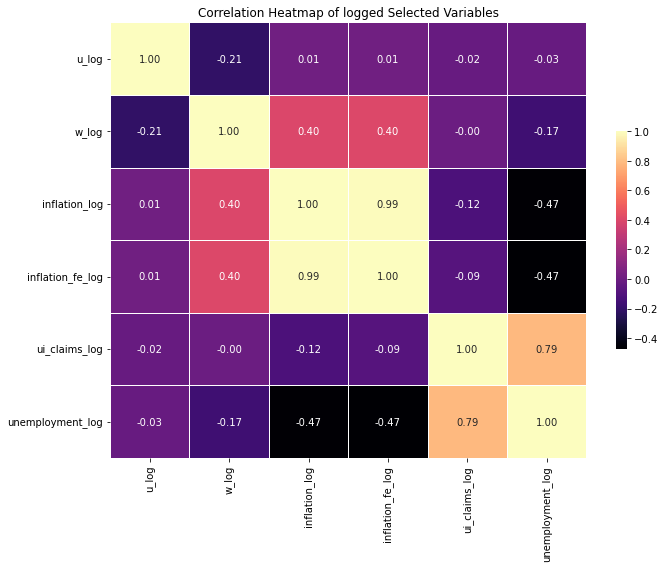

In [6]:
# Creating correlation matrix
cols_of_interest = [ 'u_log', 'w_log', 'inflation_log', 'inflation_fe_log', 'ui_claims_log', 'unemployment_log']
df_selected = df[cols_of_interest]

# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

# Adding title and adjusting layout
plt.title('Correlation Heatmap of logged Selected Variables')
plt.tight_layout()

# Display the heatmap
plt.show()

In [7]:
# Run VIF test
X = df[[ 'inflation', 'total_ui_claims', 'u_log', 'w_log']]
X = add_constant(X)  # Adds a constant term to the predictor set

# Drop rows with any NaN values only for the VIF calculation
X_dropna = X.dropna()

# Calculate VIF for each predictor using the temporary DataFrame without NaNs
vif = pd.DataFrame()
vif["variables"] = X_dropna.columns
vif["VIF"] = [variance_inflation_factor(X_dropna.values, i) for i in range(X_dropna.shape[1])]

print(vif)



         variables         VIF
0            const  320.822363
1        inflation    1.202151
2  total_ui_claims    1.003432
3            u_log    1.060400
4            w_log    1.259372


In [8]:
# Running each industry regression in a for loop

for industry in df['industry'].unique():
    # Filter the DataFrame for the current industry
    df_industry = df[df['industry'] == industry].copy()

    # Define the regression formula
    # C defines catagorical dummy variable for covid 
    formula = ('jo_log ~ C(covid) * inflation_fe_log + '
               'C(covid) * unemployment_log + '
               'C(covid) * u_log + '
               'C(covid) * w_log')

    # Fit the model with robust standard errors
    model = smf.ols(formula, data=df_industry).fit(cov_type='HC1')  # HC1 for consistency with Stata's robust option

    # Print the summary for each industry's model
    print(f"Industry: {industry}")
    print(model.summary())
    print("\n\n")



Industry: 1
                            OLS Regression Results                            
Dep. Variable:                 jo_log   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     392.4
Date:                Sat, 16 Mar 2024   Prob (F-statistic):           1.34e-85
Time:                        03:12:57   Log-Likelihood:                 128.52
No. Observations:                 132   AIC:                            -237.0
Df Residuals:                     122   BIC:                            -208.2
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------


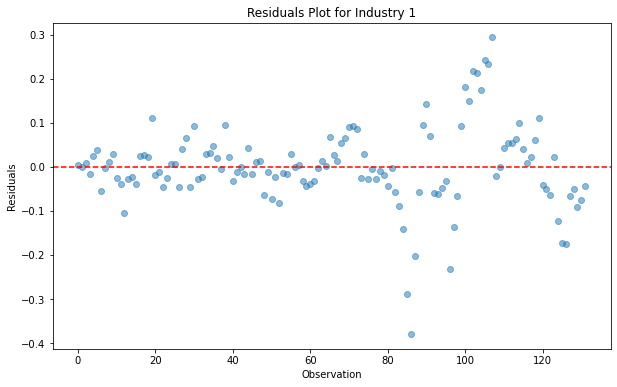

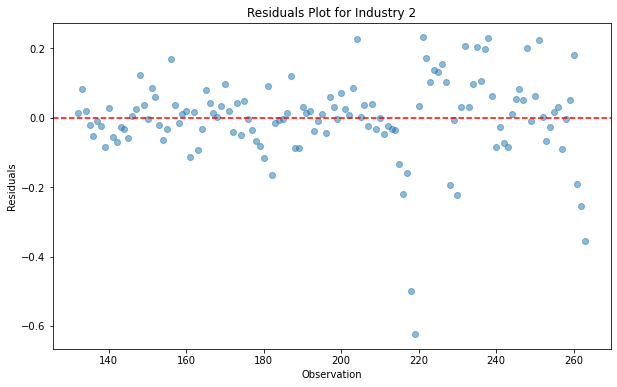

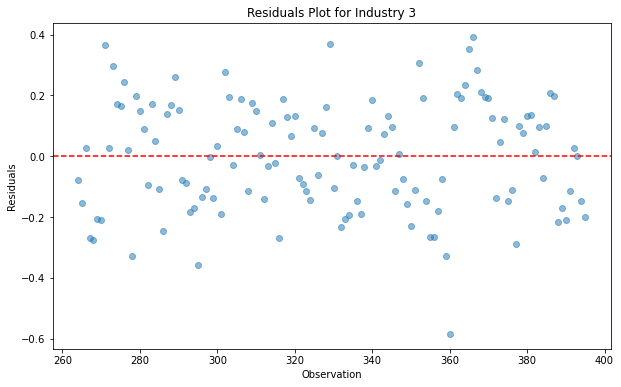

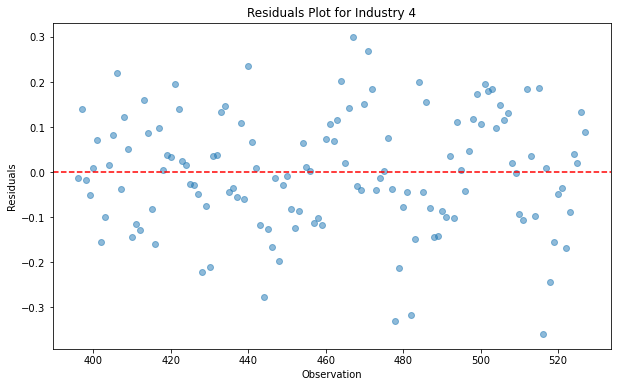

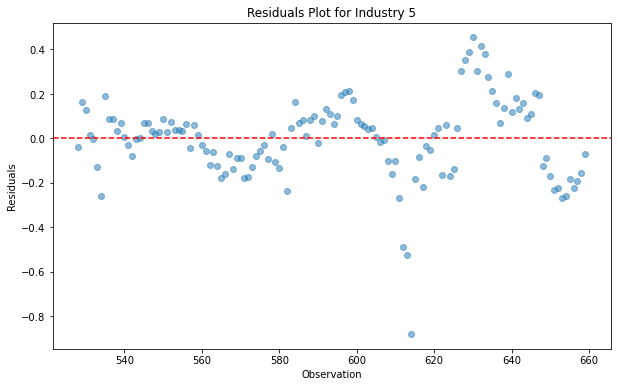

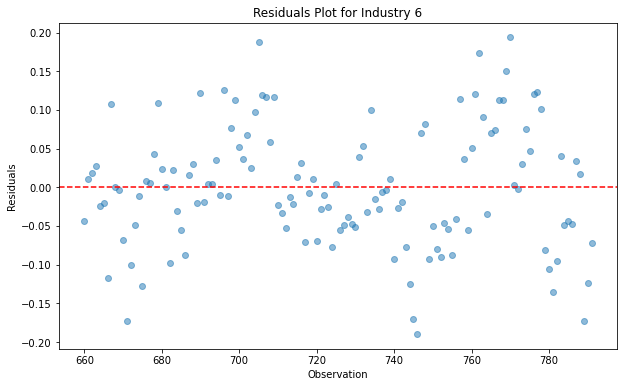

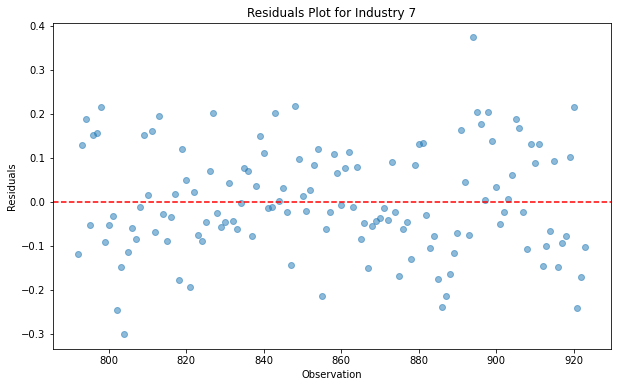

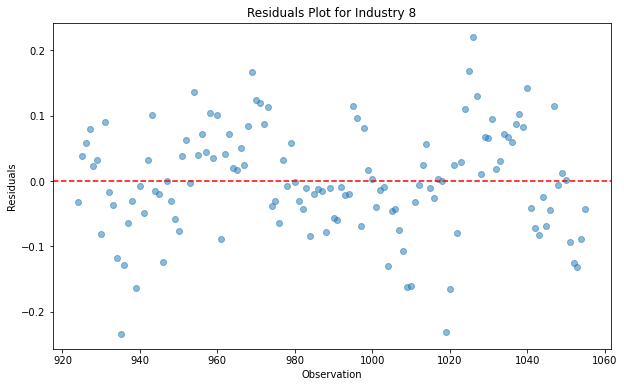

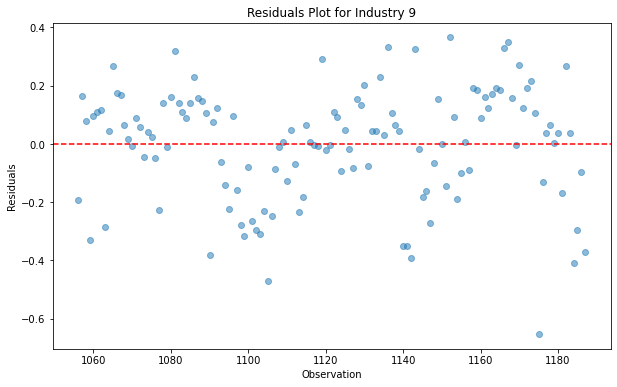

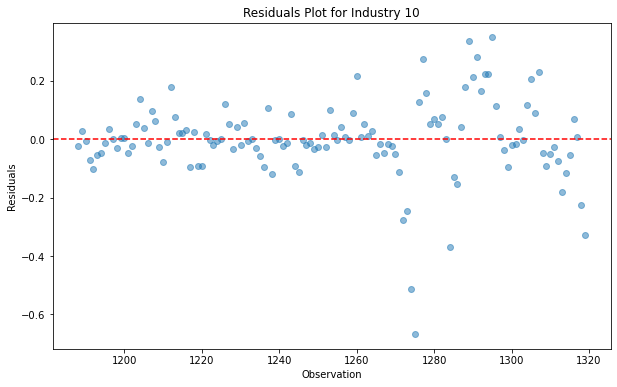

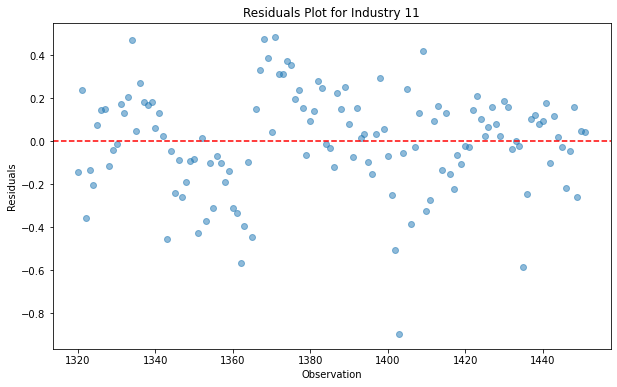

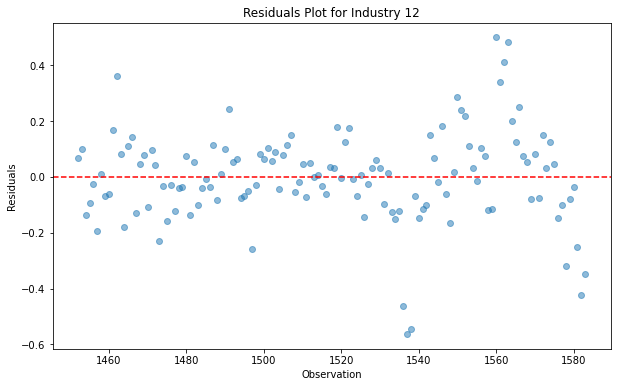

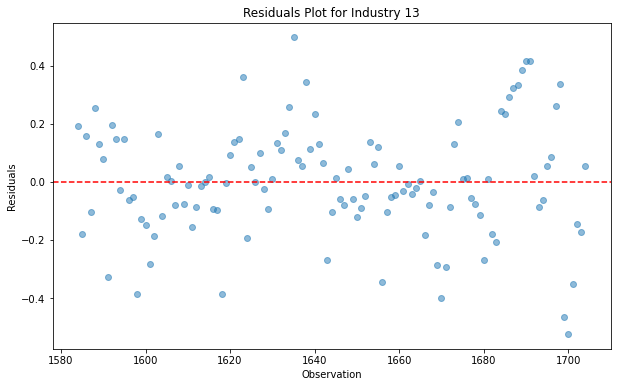

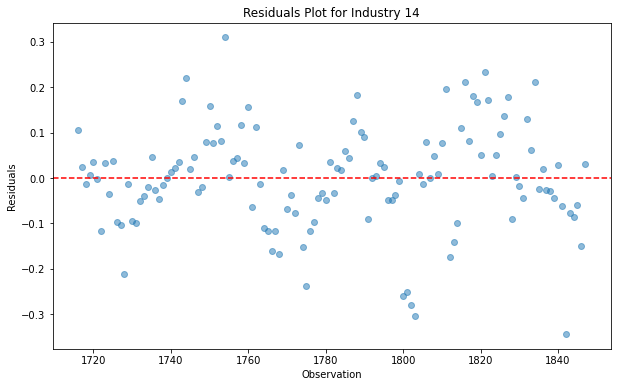

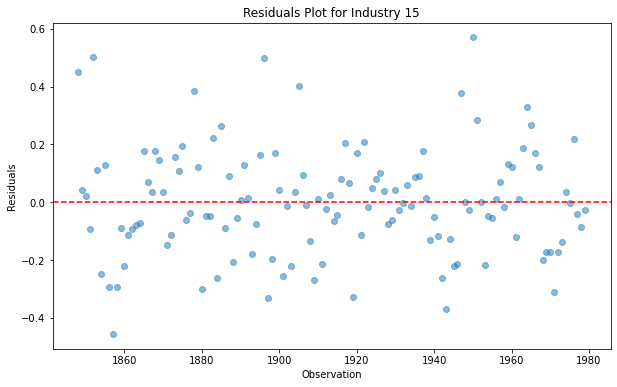

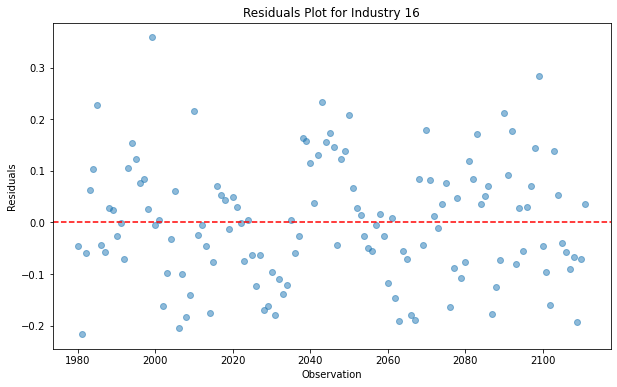

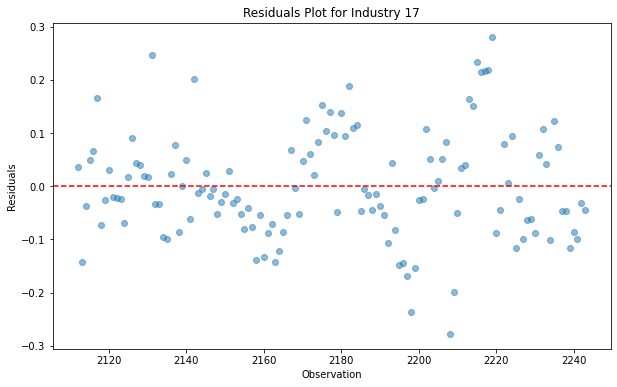

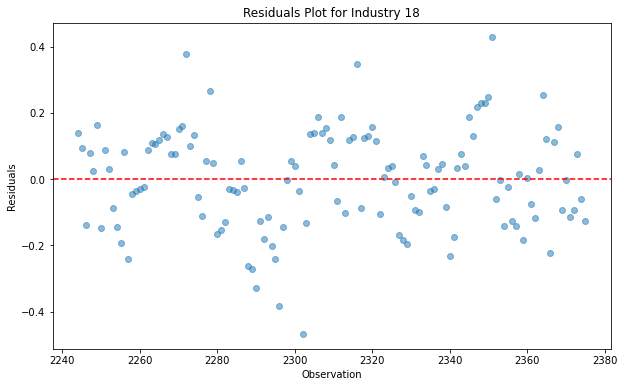

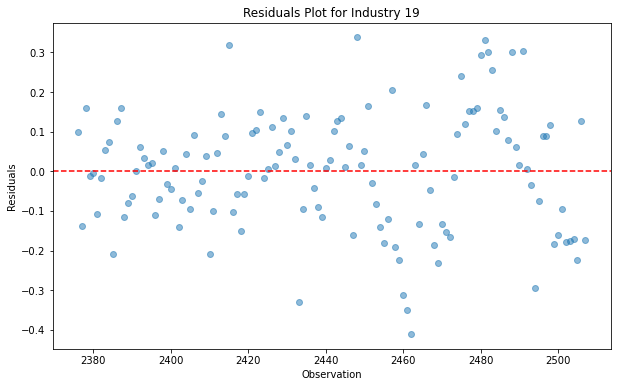

In [9]:
# Iterate plotting residuals
for industry in df['industry'].unique():
    
    df_industry = df[df['industry'] == industry].copy()

    formula = ('jo_log ~ C(covid) * inflation_fe_log + '
               'C(covid) * unemployment_log + '
               'C(covid) * u_log + '
               'C(covid) * w_log')
    model = smf.ols(formula, data=df_industry).fit(cov_type='HC1')

    # Calculate residuals
    df_industry['residuals'] = model.resid

    # Plotting residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(df_industry.index, df_industry['residuals'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Observation')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot for Industry {industry}')
    plt.show()


In [10]:
# Regressing covid and unemployment on union membership
# Iterate through each industry and run separate regressions
for industry in df['industry'].unique():
    df_industry = df[df['industry'] == industry].copy()
    formula = ('u_log ~ C(covid) * unemployment_log')
    # Fit the model with robust standard errors
    model = smf.ols(formula, data=df_industry).fit(cov_type='HC1')

    # Print the summary for each industry's model
    print(f"Industry: {industry}")
    print(model.summary())
    print("\n\n")


Industry: 1
                            OLS Regression Results                            
Dep. Variable:                  u_log   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     607.8
Date:                Sat, 16 Mar 2024   Prob (F-statistic):           1.67e-75
Time:                        03:13:02   Log-Likelihood:                 355.74
No. Observations:                 132   AIC:                            -703.5
Df Residuals:                     128   BIC:                            -692.0
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------


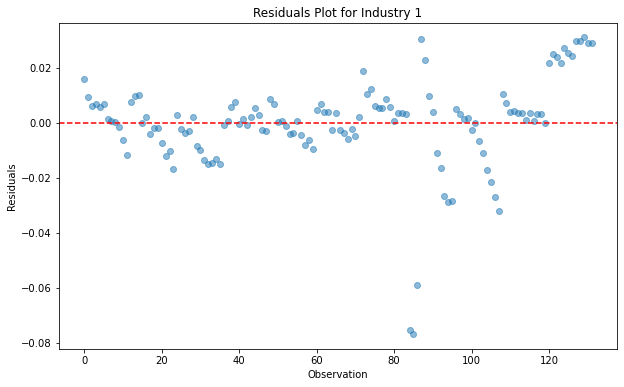

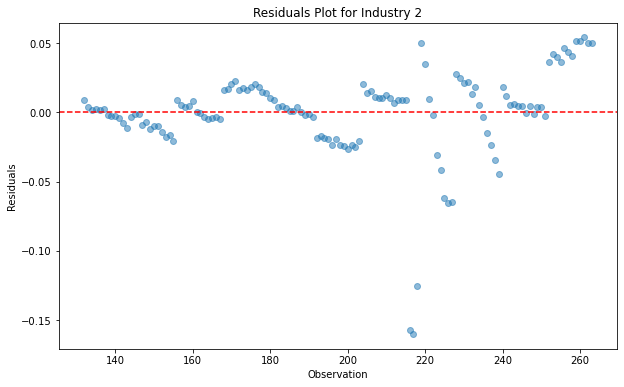

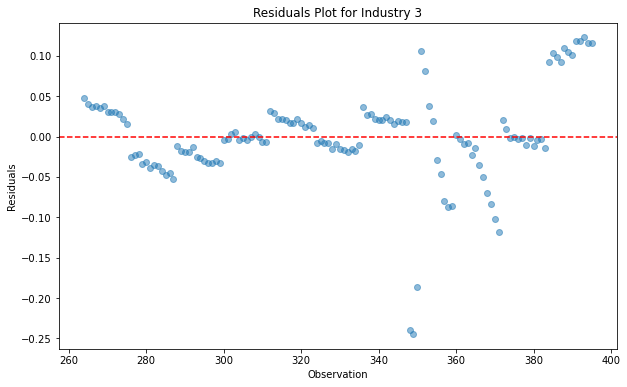

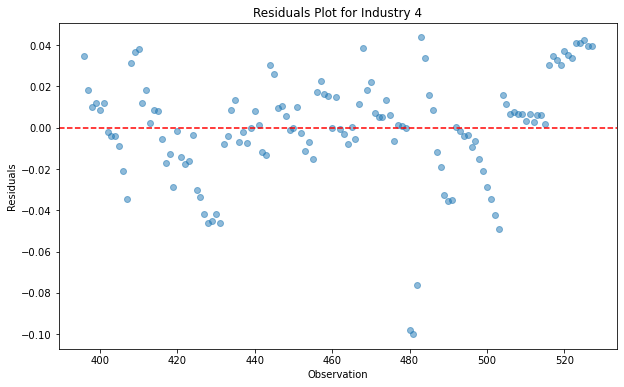

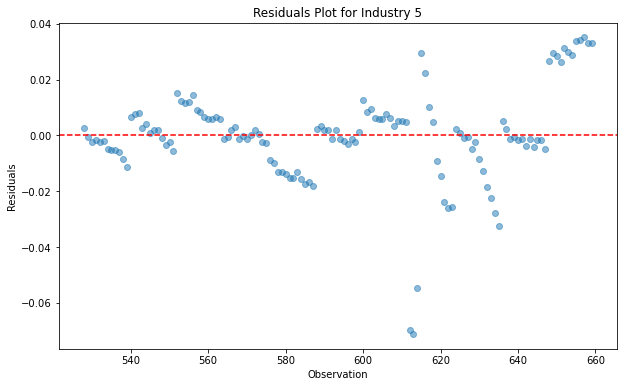

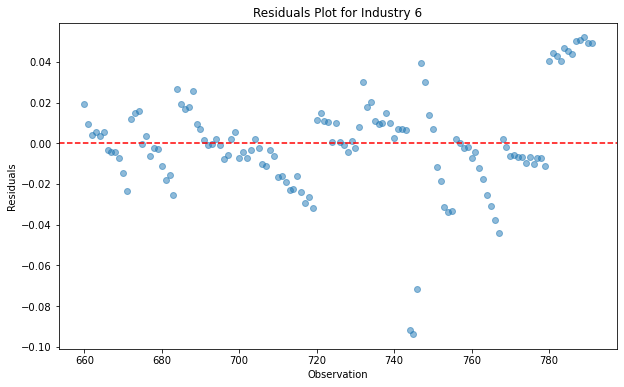

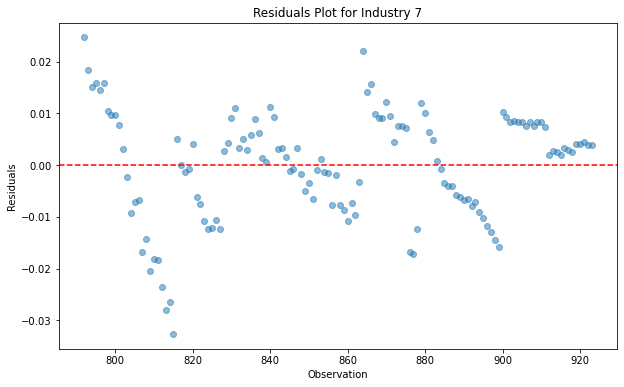

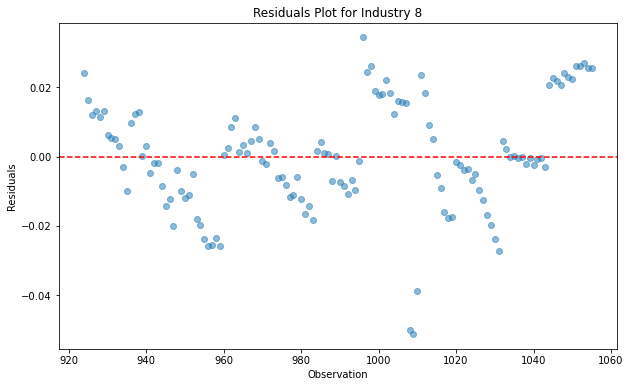

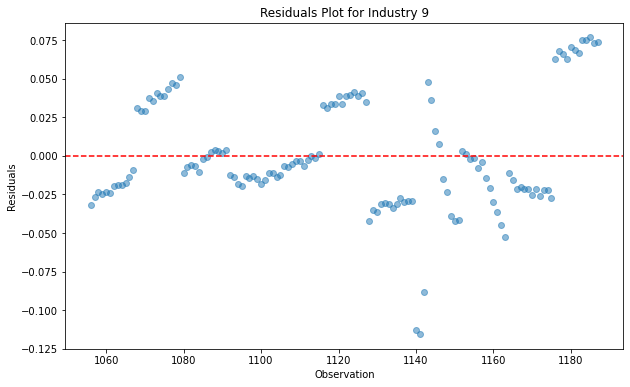

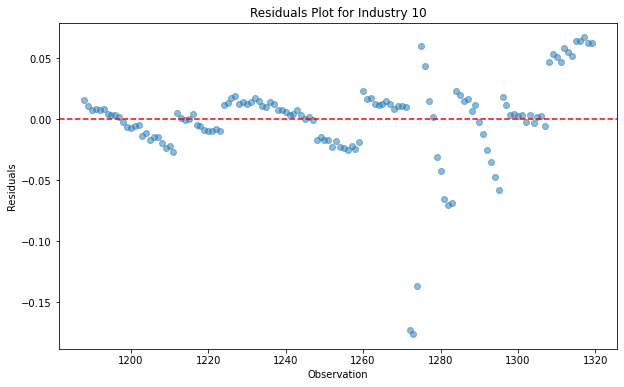

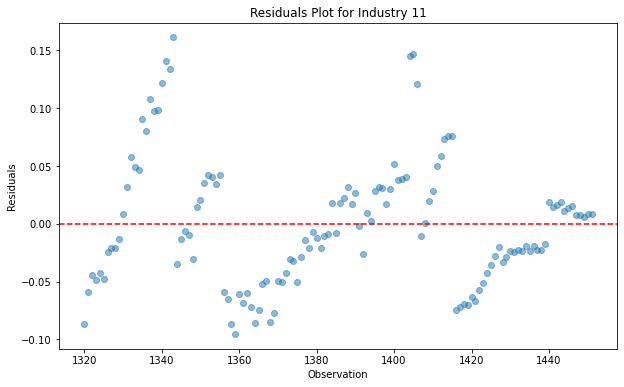

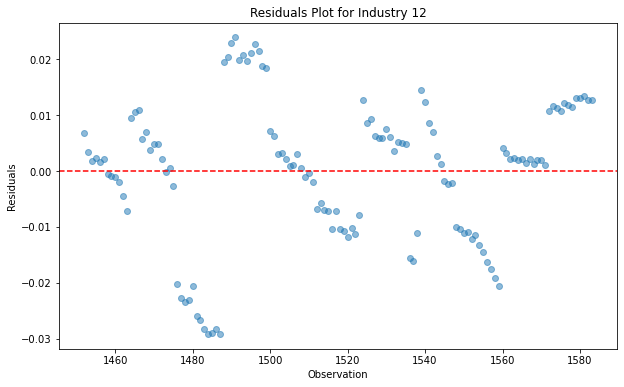

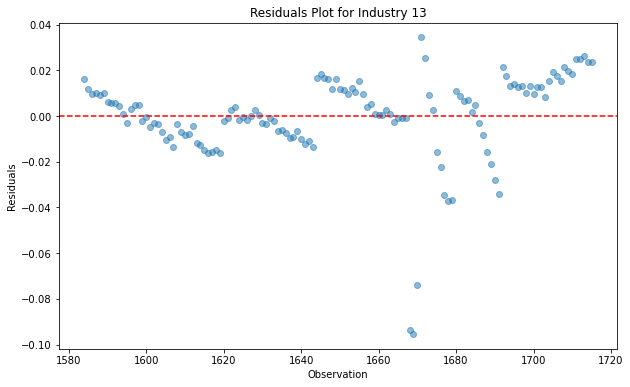

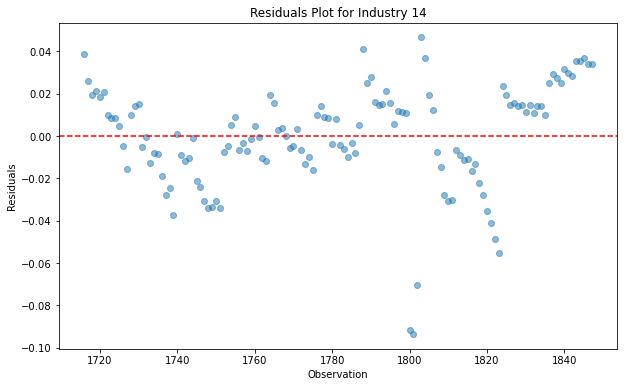

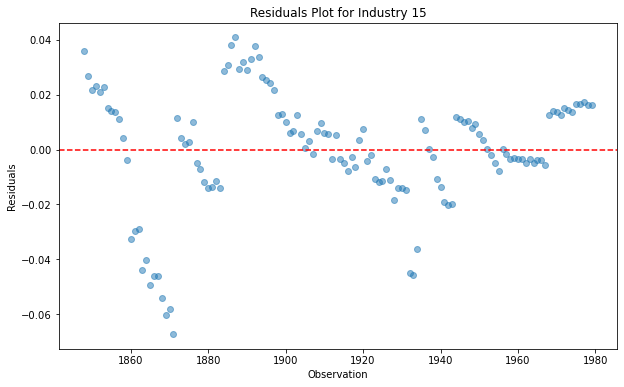

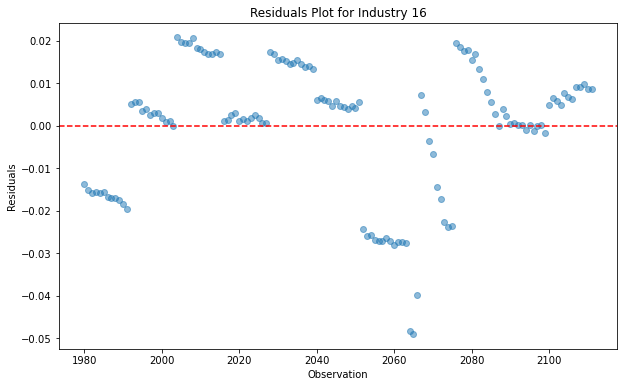

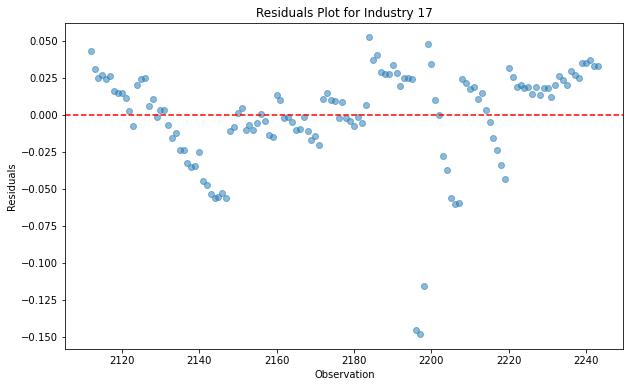

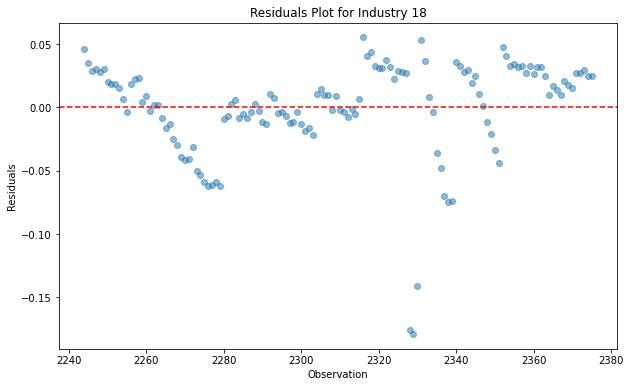

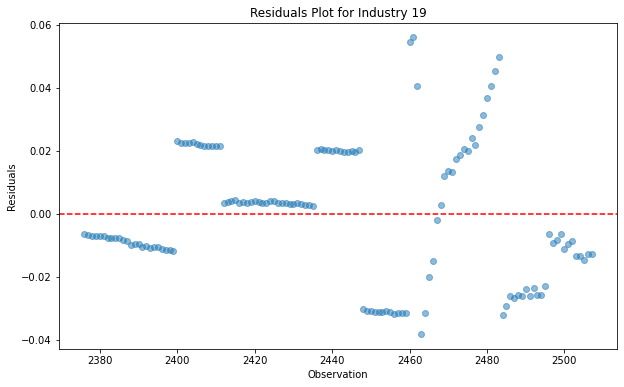

In [11]:
for industry in df['industry'].unique():
    # Filter the DataFrame for the current industry
    df_industry = df[df['industry'] == industry].copy()
    formula = ('u_log ~ C(covid) * unemployment_log')
    
    # Fit the model with robust standard errors
    model = smf.ols(formula, data=df_industry).fit(cov_type='HC1')
    
    # Calculate residuals
    df_industry['residuals'] = model.resid

    # Plotting residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(df_industry.index, df_industry['residuals'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Observation')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot for Industry {industry}')
    plt.show()

In [12]:
# Creating date variable for plotting 
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))

# Mapping groups based on essential worker definitions
group_mapping = {
    1: None,  # 'Total Private' is not classified
    2: 'Not-Essential',  # 'Accommodations and food services'
    3: 'Not-Essential',  # 'Arts and entertainment'
    4: 'Not-Essential',  # 'Construction'
    5: 'Mixed',  # 'Durable Goods Manufacturing'
    6: 'Mixed',  # 'Education (Private Sector)'
    7: 'Mixed',  # 'Financial Activities'
    8: 'Essential',  # 'Healthcare'
    9: 'Essential',  # 'Information'
    10: None,  # 'Leisure and Hospitality'
    11: 'Essential',  # 'Mining and Logging'
    12: 'Mixed',  # 'Non Durable Goods Manufacturing'
    13: None,  # 'Other Services' is not classified
    14: 'Mixed',  # 'Professional & Business Services'
    15: 'Not-Essential',  # 'Real Estate'
    16: 'Mixed',  # 'Retail Trade'
    17: 'Essential',  # 'Warehousing, Transportation and Utilities'
    18: 'Essential',  # 'Transportation'
    19: 'Essential',  # 'Wholesale Trade'
}

# Map the original industry labels to the group labels
df['group'] = df['industry'].map(group_mapping)
group_df = df[df['group'].notna()]
group_df.head()


,inflation,inflation_no_f_e,unemployment,total_ui_claims,industry,jo,u,w,year,month,covid,jo_log,u_log,w_log,inflation_log,inflation_fe_log,ui_claims_log,unemployment_log,date,group
132,231.67900,232.22900,12471,1412000,2,415,9726,13.0,2013,1,0,6.028278,9.182558,2.564949,5.445353,5.447724,14.160518,9.431161,2013-01-01,Not-Essential
133,232.93700,232.56900,11950,1412000,2,468,9726,13.0,2013,2,0,6.148468,9.182558,2.564949,5.450768,5.449187,14.160518,9.388487,2013-02-01,Not-Essential
134,232.28200,232.79401,11689,1759000,2,451,9726,13.0,2013,3,0,6.111467,9.182558,2.564949,5.447952,5.450154,14.380256,9.366404,2013-03-01,Not-Essential
135,231.79700,232.83200,11760,1389000,2,430,9726,13.0,2013,4,0,6.063785,9.182558,2.564949,5.445862,5.450317,14.144094,9.372459,2013-04-01,Not-Essential
136,231.89301,232.99600,11654,1391000,2,422,9726,13.0,2013,5,0,6.045005,9.182558,2.564949,5.446276,5.451021,14.145534,9.363404,2013-05-01,Not-Essential


In [13]:
# Mapping labels to industry
industry_labels = {
    1: 'Total Private',
    2: 'Accommodations and food services',
    3: 'Arts and entertainment',
    4: 'Construction',
    5: 'Durable Goods Manufacturing',
    6: 'Education (Private Sector)',
    7: 'Financial Activities',
    8: 'Healthcare',
    9: 'Information',
    10: 'Leisure and Hospitality',
    11: 'Mining and Logging',
    12: 'Non Durable Goods Manufacturing',
    13: 'Other Services',
    14: 'Professional & Business Services',
    15: 'Real Estate',
    16: 'Retail Trade',
    17: 'Warehousing, Transportation and Utilities',
    18: 'Transportation',
    19: 'Wholesale Trade',
}
df['industry'] = df['industry'].map(industry_labels) 

In [14]:
# Mapping colors to industry
color_mapping = {
    'Total Private': '#000000',  # Black
    'Accommodations and food services': '#FFC0CB',  # Light pink
    'Arts and entertainment': '#FF1493',  # Deep pink
    'Construction': '#A52A2A',  # Brown
    'Durable Goods Manufacturing': '#ff8c00',  # Dark Orange
    'Education (Private Sector)': '#1e90ff',  # Dodger Blue
    'Financial Activities': '#2e8b57',  # Sea Green
    'Healthcare': '#87ceeb',  # Sky Blue
    'Information': '#0000ff',  # Blue
    'Leisure and Hospitality': '#FF69B4',  # Medium pink
    'Mining and Logging': '#ff6347',  # Tomato
    'Non Durable Goods Manufacturing': '#ffa500',  # Orange
    'Other Services': '#808080',  # Grey
    'Professional & Business Services': '#32cd32',  # Lime Green
    'Real Estate': '#3cb371',  # Medium Sea Green
    'Retail Trade': '#9932cc',  # Dark Orchid
    'Warehousing, Transportation and Utilities': '#7851A9',  # Royal Purple
    'Transportation': '#4B0082',  # Indigo
    'Wholesale Trade': '#800080',  # Purple
}


In [15]:
# Creating seperated dataframes for the purposes of plotting
# 'filtered_df' will exclude rows where 'industry' is 'Total Private'
filtered_df = df[df['industry'] != 'Total Private']

# Now, create 'filtered_df1' by excluding multiple categories
excluded_industries = [
    'Accommodations and food services',
    'Leisure and Hospitality',
    'Retail Trade',
    'Education (Private Sector)',
    'Healthcare',
    'Professional & Business Services',
    'Warehousing, Transportation and Utilities'
]

# Create 'filtered_df1' from 'filtered_df' excluding the listed industries
filtered_df1 = filtered_df[~filtered_df['industry'].isin(excluded_industries)]
# Get unique industries from the filtered DataFrame
unique_industries = filtered_df1['industry'].unique()

# Print the unique industries
print(unique_industries)

industries_first = [
    'Mining and Logging',
    'Construction',
    'Durable Goods Manufacturing',
    'Non Durable Goods Manufacturing',
    'Wholesale Trade',
    'Transportation'
]

# Create the first filtered dataframe
filtered_df2 = filtered_df1[filtered_df1['industry'].isin(industries_first)]

industries_second = [
    'Information',
    'Financial Activities',
    'Real Estate',
    'Arts and entertainment',
    'Other Services'
]

# Create the second filtered dataframe
filtered_df3 = filtered_df1[filtered_df1['industry'].isin(industries_second)]

['Arts and entertainment' 'Construction' 'Durable Goods Manufacturing'
 'Financial Activities' 'Information' 'Mining and Logging'
 'Non Durable Goods Manufacturing' 'Other Services' 'Real Estate'
 'Transportation' 'Wholesale Trade']


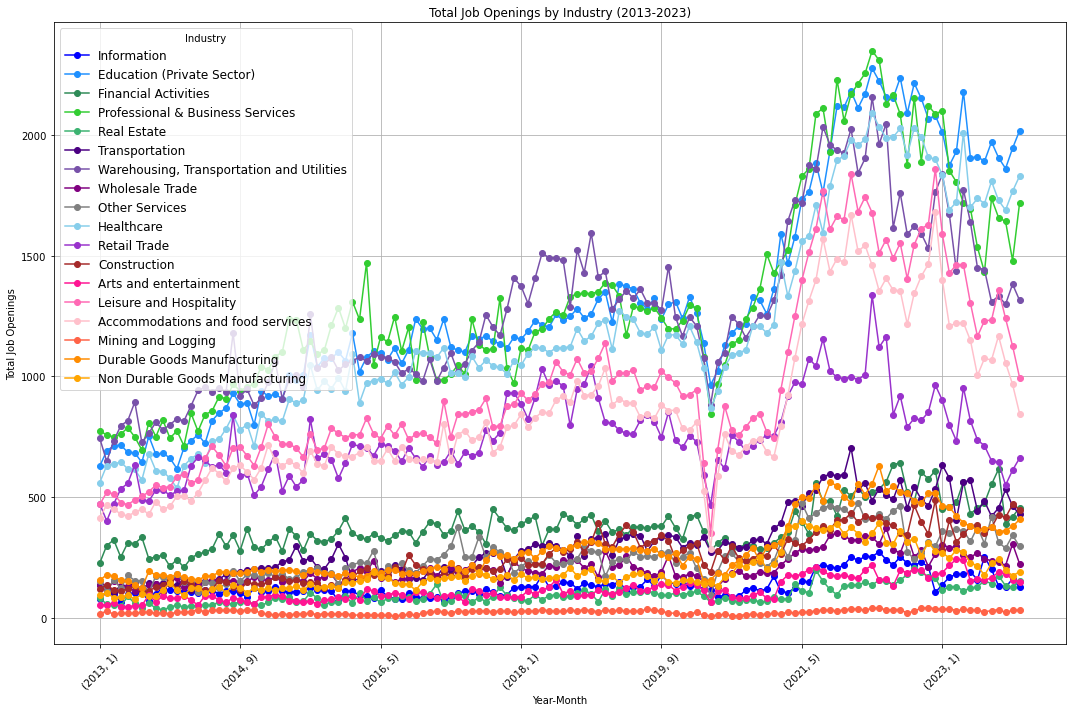

In [16]:
# Plotting job openings over time across industries minus total private 
grouped_df1 = filtered_df.groupby(['industry', 'year', 'month'])['jo'].mean().reset_index()

# Create the pivot table
pivot_df1 = grouped_df1.pivot_table(index=['year', 'month'], columns='industry', values='jo')

# Ensure the columns are ordered consistently with the color mapping
ordered_columns1 = sorted(pivot_df1.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df1 = pivot_df1[ordered_columns1]

# Plotting with color mapping
pivot_df1.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Total Job Openings by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Total Job Openings')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


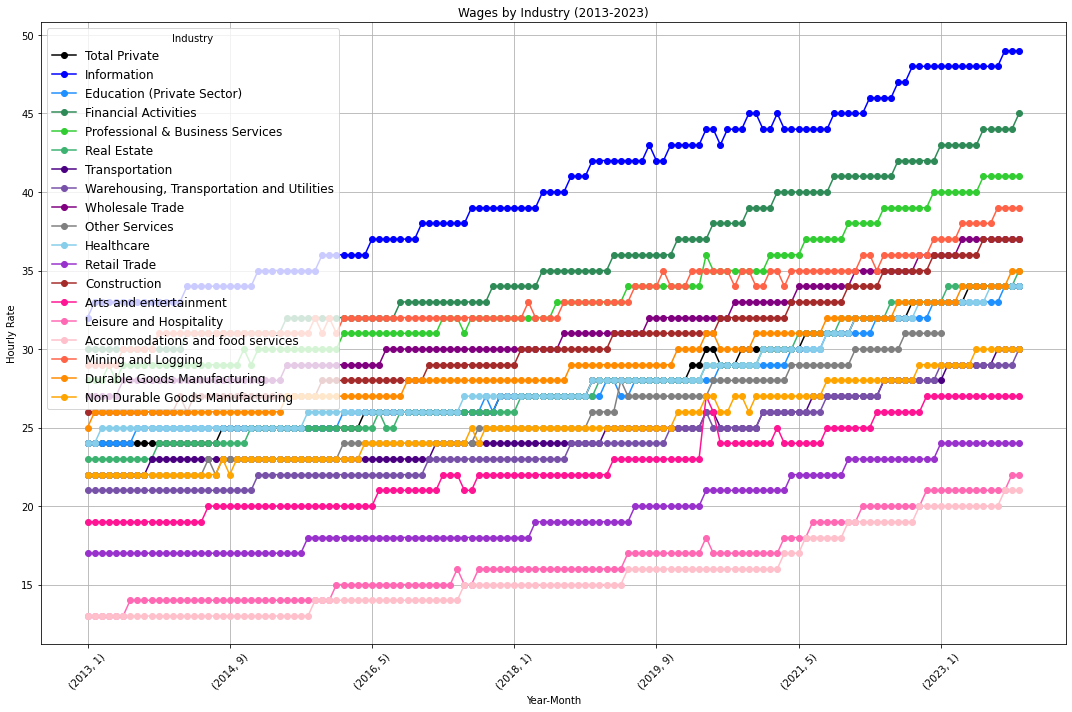

In [17]:
# Plotting wages across industries over time 
grouped_df2 = df.groupby(['industry', 'year', 'month'])['w'].mean().reset_index()

# Recreate the pivot table
pivot_df2 = grouped_df2.pivot_table(index=['year', 'month'], columns='industry', values='w')

ordered_columns2 = sorted(pivot_df2.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df2 = pivot_df2[ordered_columns2]

pivot_df2.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Wages by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Hourly Rate')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


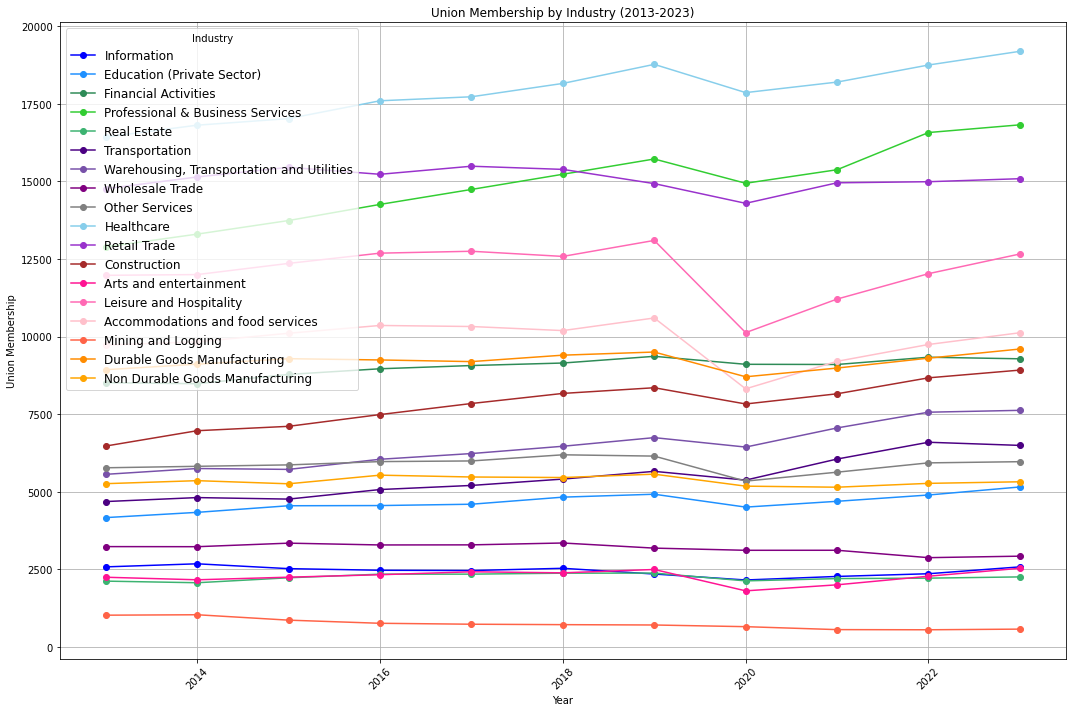

In [18]:
# Plotting union membership over time, only had anual data
grouped_df3 = df.groupby(['industry', 'year', 'month'])['u'].mean().reset_index()

# Recreate the pivot table
pivot_df3 = grouped_df3.pivot_table(index=['year'], columns='industry', values='u')

ordered_columns3 = sorted(pivot_df3.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df3 = pivot_df3[ordered_columns1]

pivot_df3.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Union Membership by Industry (2013-2023)')
plt.xlabel('Year')
plt.ylabel('Union Membership')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


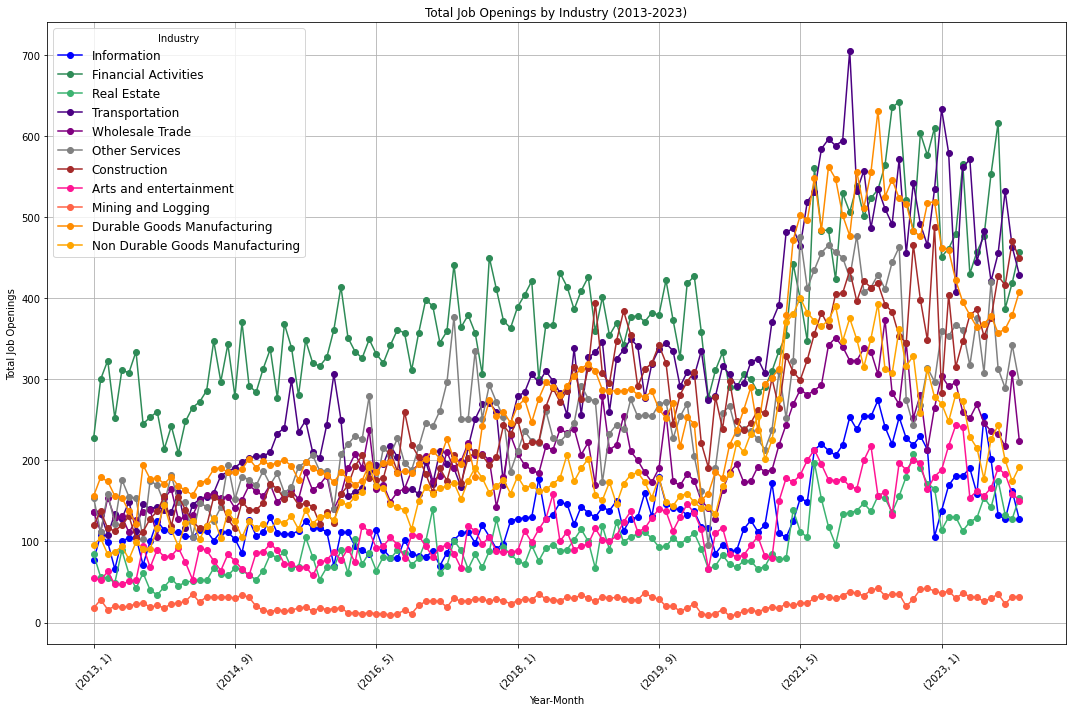

In [19]:
# Plotting job openings in industries with fewer workers for better visualization
grouped_df4 = filtered_df1.groupby(['industry', 'year', 'month'])['jo'].mean().reset_index()
# Recreate the pivot table
pivot_df4 = grouped_df4.pivot_table(index=['year', 'month'], columns='industry', values='jo')

ordered_columns4 = sorted(pivot_df4.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df4 = pivot_df4[ordered_columns4]

pivot_df4.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Total Job Openings by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Total Job Openings')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

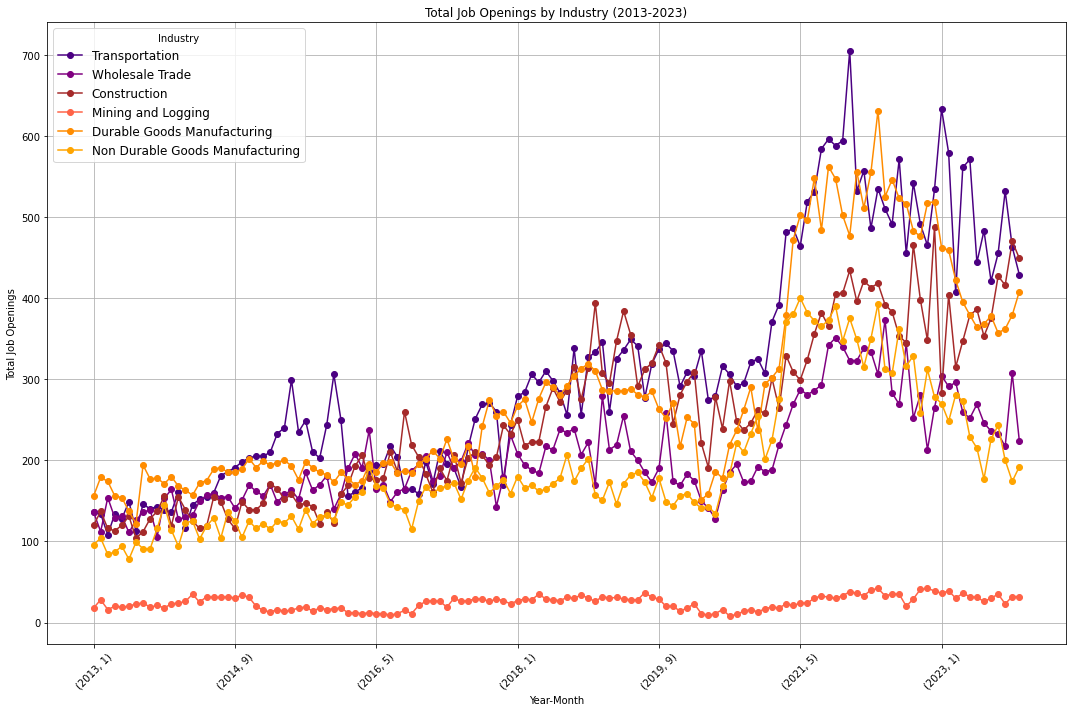

In [20]:
# Plotting manufacturing, minning and logging, construction, wholesale trade and transportation 
grouped_df5 = filtered_df2.groupby(['industry', 'year', 'month'])['jo'].mean().reset_index()
# Recreate the pivot table
pivot_df5 = grouped_df5.pivot_table(index=['year', 'month'], columns='industry', values='jo')

ordered_columns5 = sorted(pivot_df5.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df5 = pivot_df5[ordered_columns5]

pivot_df5.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Total Job Openings by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Total Job Openings')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

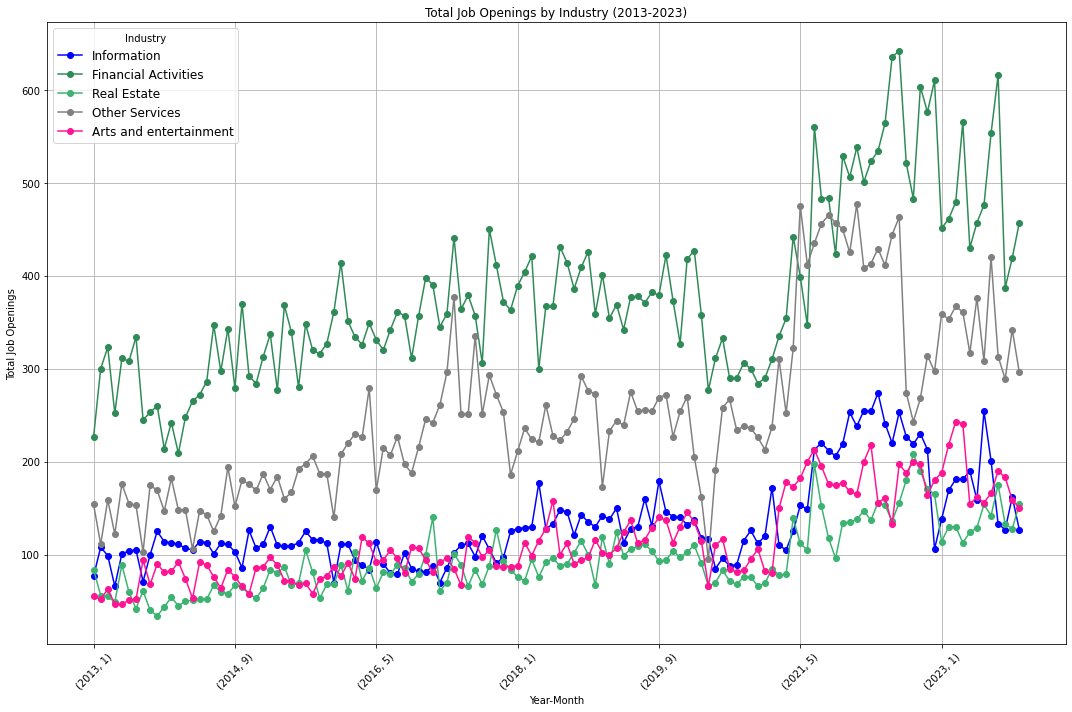

In [21]:
# Plotting financial services, real estate, information, other services and arts and entertainment
grouped_df6 = filtered_df3.groupby(['industry', 'year', 'month'])['jo'].mean().reset_index()
# Recreate the pivot table
pivot_df6 = grouped_df6.pivot_table(index=['year', 'month'], columns='industry', values='jo')

ordered_columns6 = sorted(pivot_df6.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df6 = pivot_df6[ordered_columns6]

pivot_df6.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Total Job Openings by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Total Job Openings')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

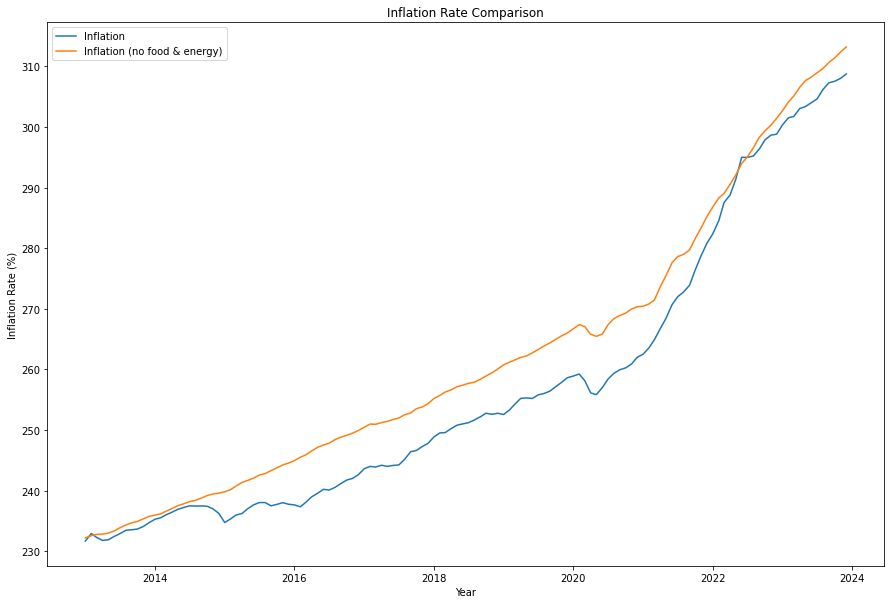

In [22]:
plt.figure(figsize=(15, 10))

# Plotting inflation levels over time 
df_sorted = df.sort_values('date')

# Plotting the sorted data
plt.plot(df_sorted['date'], df_sorted['inflation'], label='Inflation')
plt.plot(df_sorted['date'], df_sorted['inflation_no_f_e'], label='Inflation (no food & energy)')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.title('Inflation Rate Comparison')
plt.legend()

plt.show()


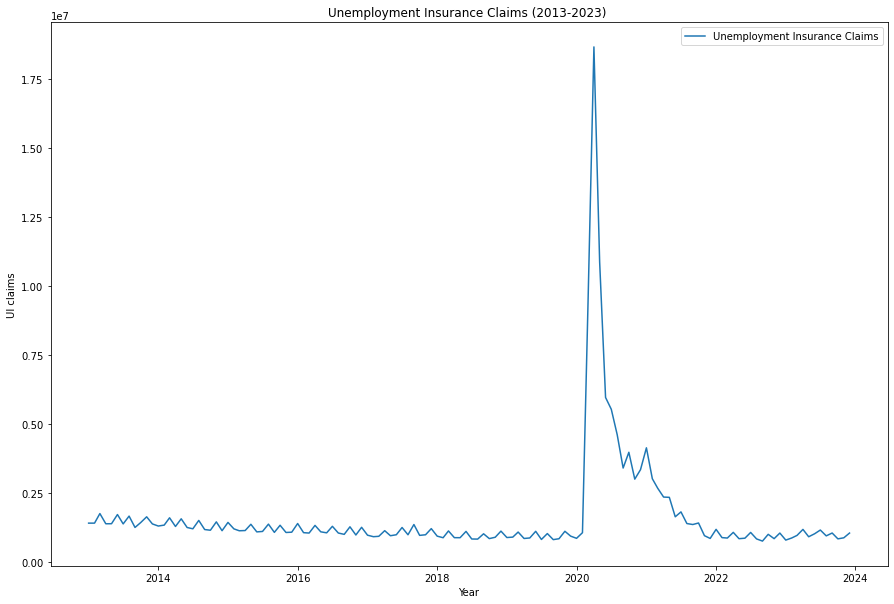

In [23]:
# Plotting unemployment insurance claims over time
plt.figure(figsize=(15, 10))

# Sort the DataFrame by the date column
df_sorted = df.sort_values('date')

# Plotting the sorted data

plt.plot(df_sorted['date'], df_sorted['total_ui_claims'], label='Unemployment Insurance Claims')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('UI claims')
plt.title('Unemployment Insurance Claims (2013-2023) ')
plt.legend()

plt.show()


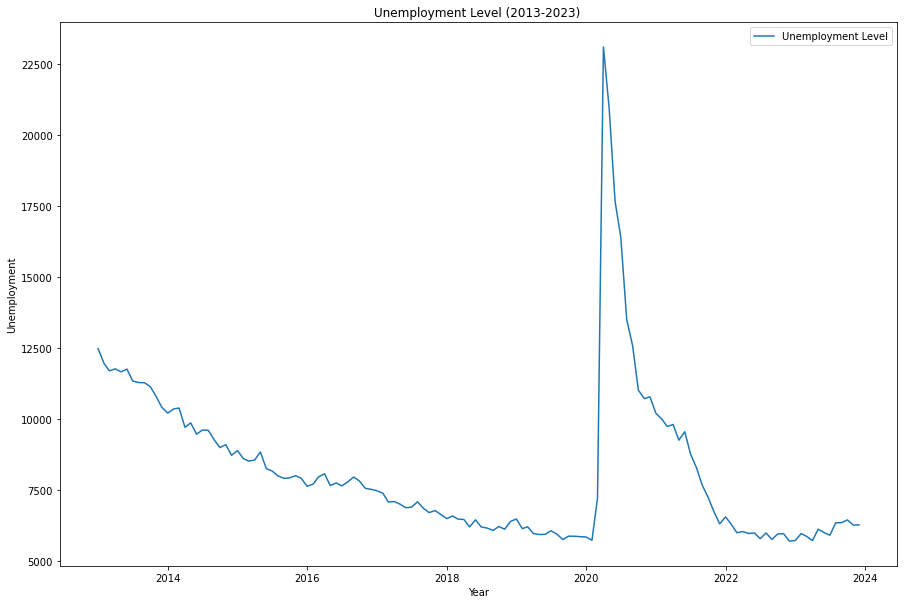

In [24]:
# Plotting unemployment level over time
plt.figure(figsize=(15, 10))

# Sort the DataFrame by the date column
df_sorted = df.sort_values('date')

# Plotting the sorted data

plt.plot(df_sorted['date'], df_sorted['unemployment'], label='Unemployment Level')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Unemployment')
plt.title('Unemployment Level (2013-2023) ')
plt.legend()

plt.show()

In [25]:
# Plotting the change in the regression coeficients over time

# First: Initialize a DataFrame to store the coefficients

# Second: Initialize a dictionary to store the regression results

regression_results = {}

# Loop through each group
for group in group_df['group'].unique():
    # Loop through each year
    for year in group_df['year'].unique():
        # Subset the DataFrame for the current group and year
        group_year_data = group_df[(group_df['group'] == group) & (group_df['year'] == year)]
        
        # Check if the subset is empty; if so, skip to the next iteration
        if group_year_data.empty:
            continue
        
        # Run regression (can swap inflation_log and inflation_fe_log, as well as ui_claims_log and unemployment_log)
        result = smf.ols(formula='jo_log ~ inflation_fe_log + unemployment_log + u_log + w_log', data=group_year_data).fit(cov_type='HC1')
        
        # Store the result object, now correctly including 'year' in the key
        regression_results[(group, year)] = result.params

# Print the results
# Then, when printing, directly use the stored result object
for (group, year), params in regression_results.items():
    print(f"Results for group: {group}, year: {year}")
    for param, value in params.items():
        print(f"  {param}: {value}")
    
    # Run regression again to get the current result object for printing the summary
    group_year_data = group_df[(group_df['group'] == group) & (group_df['year'] == year)]
    if not group_year_data.empty:
        result = smf.ols(formula='jo_log ~ inflation_fe_log + unemployment_log + u_log + w_log', data=group_year_data).fit(cov_type='HC1')
        print(result.summary())
    print()  #

Results for group: Not-Essential, year: 2013
  Intercept: -64.0808414320627
  inflation_fe_log: 10.89332575314188
  unemployment_log: 0.5481086929232788
  u_log: 0.9602458533496525
  w_log: -1.2421709059372
                            OLS Regression Results                            
Dep. Variable:                 jo_log   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     394.1
Date:                Sat, 16 Mar 2024   Prob (F-statistic):           2.88e-33
Time:                        03:13:16   Log-Likelihood:                 9.9362
No. Observations:                  48   AIC:                            -9.872
Df Residuals:                      43   BIC:                           -0.5164
Df Model:                           4                                         
Covariance Type:                  HC1                                         
   

In [28]:
# Convert regression results to a DataFrame for easier plotting
plot_data = []
for (group, year), params in regression_results.items():
    for var, coef in params.items():
        plot_data.append({
            'group': group, 
            'year': year, 
            'variable': var, 
            'coefficient': coef
        })

coefficients_df = pd.DataFrame(plot_data)


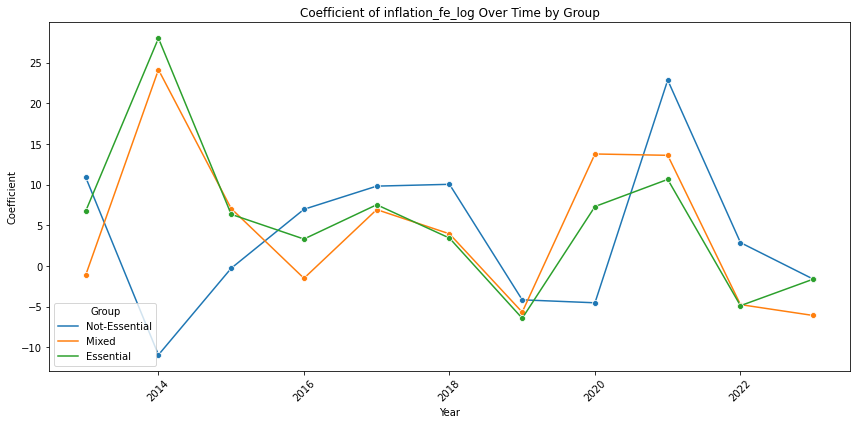

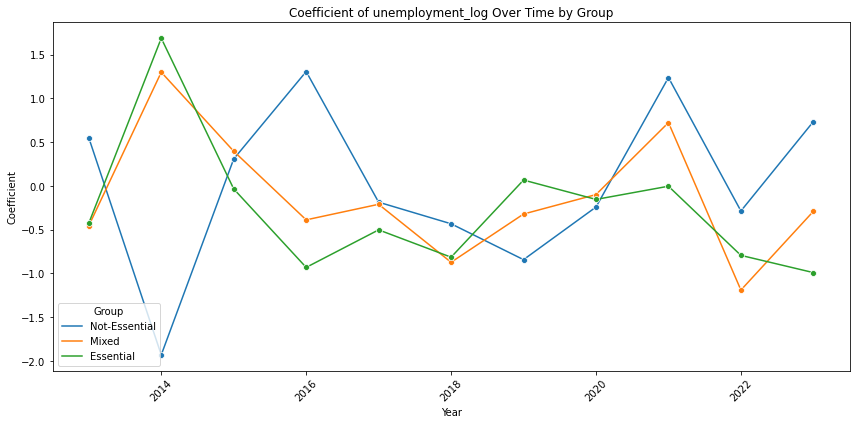

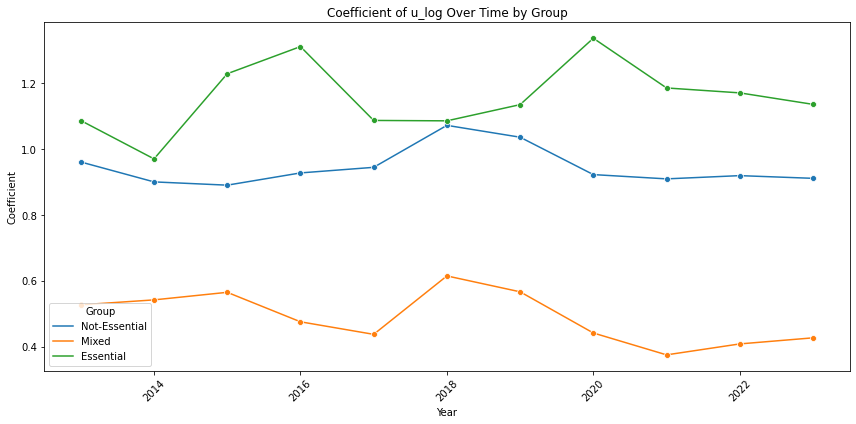

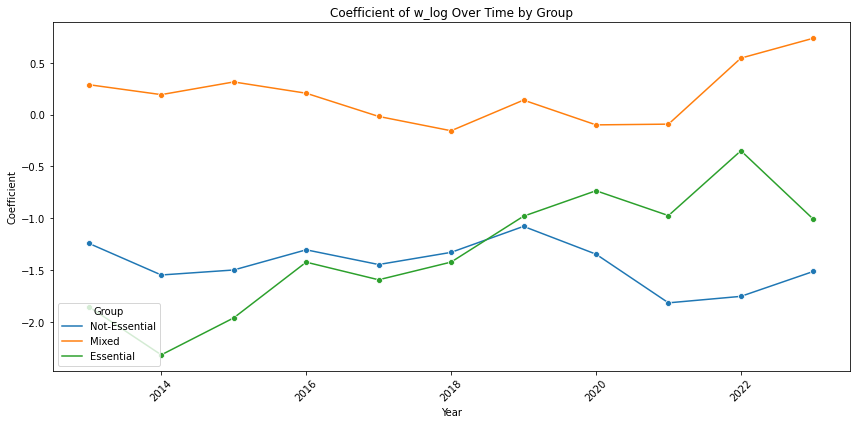

In [33]:
# Creating list of variables to plot over time
variables_to_plot = ['inflation_fe_log', 'unemployment_log', 'u_log', 'w_log']
# Plotting each category for each variable
for variable_to_plot in variables_to_plot:
    coefficients_df_filtered = coefficients_df[coefficients_df['variable'] == variable_to_plot]

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=coefficients_df_filtered, x='year', y='coefficient', hue='group', marker='o', linestyle='-')
    plt.title(f'Coefficient of {variable_to_plot} Over Time by Group')
    plt.xlabel('Year')
    plt.ylabel('Coefficient')
    plt.xticks(rotation=45)
    plt.legend(title='Group', loc='lower left')
    plt.tight_layout()
    plt.show()
